In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10000)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt

In [2]:
#%%

# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column
 
# print(time)
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_sun = np.array(time_series_1_sun) # convert it to array [shape(24, 4001)]

# %% 
# 1.4 SUN

file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')

# temperature
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

# print(time)
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)#[shape(24, 1313)]

# %%

# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
 
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]

outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
scaler = MinMaxScaler()
 
# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding


time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))
 
#shape[(24, 4794, 1) (24, 4794, 1) (4794, 5) (24, 4794, 1)]

In [3]:
# Calculate average values for time_series_1_sun
time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
     

# Calculate average values for time_series_1_4_sun
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1

# Calculate average values for outdoor_panels_power
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 # Set negative values to 0
        b += 1

# Stack the outdoor conditions
outdoor_conditions_stacked = np.stack([outdoor_conditions_normalized ] * 12, axis=0)


In [5]:
def smooth_and_replace(array, window_length, polyorder):
    smoothed_array = np.zeros_like(array)
    t=0
    for i in range(array.shape[0]):
        time_series = array[i, :, 0]
        # Apply Savitzky-Golay filter to smooth the time series
        smoothed_series = savgol_filter(time_series, window_length+t, polyorder)
        # Set negative values to 0
        smoothed_series[smoothed_series < 0] = 0
        smoothed_array[i, :, 0] = smoothed_series
        t=t+1
    return smoothed_array

# Function to add noise to the array
'''def add_noise(array, noise_std):
    noise = np.random.normal(loc=0, scale=noise_std, size=array.shape)
    noisy_array = array + noise
    # Set negative values to 0 after adding noise
    noisy_array[noisy_array < 0] = 0
    return noisy_array'''

# Apply smoothing and replace negative values for outdoor_panels_power_average
'''time_series_1=time_series_1_sun[0:10,:,:]
time_series_1_sun_average=np.concatenate((time_series_1,time_series_1_sun_average), axis=0)
outdoor_panel_power_1=outdoor_panels_power[0:10,:,:]
outdoor_panels_power_average=np.concatenate((outdoor_panel_power_1,outdoor_panels_power_average), axis=0)'''

print(outdoor_panels_power_average.shape,time_series_1_sun_average.shape)
outdoor_panels_power_average= smooth_and_replace(outdoor_panels_power_average, window_length=20, polyorder=3)
 
# Apply smoothing and replace negative values for time_series_1_sun_average
time_series_1_sun_average= smooth_and_replace(time_series_1_sun_average, window_length=20, polyorder=3)

# Add noise to the smoothed arrays
''''noise_std_outdoor = 0.1  # Adjust the standard deviation for the desired noise level
noise_std_time_series = 0.1  # Adjust the standard deviation for the desired noise level

k=0
c=0
for i in range(outdoor_panels_power_average.shape[0]):
 outdoor_panels_power_average[i,:,:]= add_noise(outdoor_panels_power_average[i,:,:], noise_std_outdoor+k)
 time_series_1_sun_average[i,:,:] = add_noise(time_series_1_sun_average[i,:,:], noise_std_time_series+c)
 k=k+0.005
 c=c+0.005'''

(12, 4794, 1) (12, 4794, 1)


"'noise_std_outdoor = 0.1  # Adjust the standard deviation for the desired noise level\nnoise_std_time_series = 0.1  # Adjust the standard deviation for the desired noise level\n\nk=0\nc=0\nfor i in range(outdoor_panels_power_average.shape[0]):\n outdoor_panels_power_average[i,:,:]= add_noise(outdoor_panels_power_average[i,:,:], noise_std_outdoor+k)\n time_series_1_sun_average[i,:,:] = add_noise(time_series_1_sun_average[i,:,:], noise_std_time_series+c)\n k=k+0.005\n c=c+0.005"

In [6]:
window_size = 30  # Adjust the window size as per your requirements

time_series_1_sun_average_ma = np.zeros((12, 4794, 1))
for panel in range(12):
    for point in range(4794):
        if point < window_size-1:
            # If there are not enough previous points, use the current value
            time_series_1_sun_average_ma[panel, point] = time_series_1_sun_average[panel, point]
        else:
            # Compute the moving average using the previous window_size points
            average = np.mean(time_series_1_sun_average[panel, point-window_size+1:point+1])
            time_series_1_sun_average_ma[panel, point] = average

time_series_1_sun_average_global_diff = np.zeros((12, 4794, 1))
for panel in range(12):
    global_mean = np.mean(time_series_1_sun_average[panel])
    time_series_1_sun_average_global_diff[panel] = time_series_1_sun_average[panel] - global_mean

window_size = 10  # Adjust the window size as per your requirements
ema_values = np.zeros((12, 4794, 1))
# Compute EMA for each panel
for panel_idx in range(ema_values.shape[0]):
    panel_data = pd.Series(time_series_1_sun_average[panel_idx, :, 0])
    ema = panel_data.ewm(span=window_size).mean()
    ema_values[panel_idx, :, 0] = ema.values


fourier_transform = np.fft.fft(time_series_1_sun_average, axis=1)
frequencies = np.fft.fftfreq(time_series_1_sun_average.shape[1])
magnitudes = np.abs(fourier_transform)
magnitudes_db = 20 * np.log10(magnitudes)
all_new_features = np.concatenate((time_series_1_sun_average ,time_series_1_sun_average_ma ,time_series_1_sun_average_global_diff, outdoor_conditions_stacked), axis=2)
'''all_new_features_1 = np.concatenate((time_series_1_sun[0:20,:,:],  outdoor_conditions_stacked_2), axis=2)
all_new_features = np.concatenate((all_new_features ,  all_new_features_1), axis=0)
outdoor_panels_power_1=outdoor_panels_power[0:20,:,:]
outdoor_panels_power_average= np.concatenate((outdoor_panels_power_average,  outdoor_panels_power_1), axis=0)'''
print(all_new_features.shape)
print(outdoor_panels_power_average.shape)

(12, 4794, 8)
(12, 4794, 1)


In [7]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU for computations.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for computations.')

CUDA is not available. Using CPU for computations.


In [8]:
# Convert and transfer training data to the selected device
all_new_features_train=all_new_features[0:10, :, :].astype(np.float32)
all_new_features_train= torch.from_numpy(all_new_features_train).float().to(device)
target = torch.from_numpy(outdoor_panels_power_average[0:10, :, :]).float().to(device)
'''train_im = torch.from_numpy(time_series_1_sun_average[0:10, :, :]).float().to(device)
target = torch.from_numpy(outdoor_panels_power_average[0:30, :, :]).float().to(device)
train_oc = torch.from_numpy(outdoor_conditions_stacked[0:30, :, :]).float().to(device)'''
scaler1 = StandardScaler()
'''num_samples, num_features, num_channels = all_new_features_train.shape
all_new_features_2d = np.reshape(all_new_features_train, (num_samples, num_features * num_channels))
all_new_features_train_scaled = scaler1.fit_transform(all_new_features_2d)
all_new_features_train_scaled  = np.reshape(all_new_features_train_scaled , (num_samples, num_features, num_channels))'''
 

'''all_new_features_train_scaled = all_new_features_train.reshape(-1, 1)
all_new_features_train_scaled = scaler1.fit_transform(all_new_features_train_scaled)
all_new_features_train_scaled = all_new_features_train_scaled.reshape(all_new_features_train_scaled.shape)
all_new_features_train_scaled =torch.from_numpy(all_new_features_train_scaled ).float().to(device)
all_new_features_train_scaled=all_new_features_train_scaled.view(8,4794,9)
all_new_features_train_scaled.shape'''

'all_new_features_train_scaled = all_new_features_train.reshape(-1, 1)\nall_new_features_train_scaled = scaler1.fit_transform(all_new_features_train_scaled)\nall_new_features_train_scaled = all_new_features_train_scaled.reshape(all_new_features_train_scaled.shape)\nall_new_features_train_scaled =torch.from_numpy(all_new_features_train_scaled ).float().to(device)\nall_new_features_train_scaled=all_new_features_train_scaled.view(8,4794,9)\nall_new_features_train_scaled.shape'

In [44]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers

        self.lstm_layers = nn.ModuleList()
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True))
        for _ in range(num_layers - 1):
            self.lstm_layers.append(nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True))

        self.highway_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.highway_layers.append(nn.Linear(hidden_dim * 2, hidden_dim * 2))

        self.attention = nn.Linear(hidden_dim * 2, 1)

        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.5)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.kaiming_normal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0.1)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        for i in range(self.num_layers):
            if i == 0:
                lstm_output, hidden = self.lstm_layers[i](x)
            else:
                lstm_output,hidden = self.lstm_layers[i](lstm_output)

            highway_input = lstm_output + F.relu(self.highway_layers[i](lstm_output))
            lstm_output = lstm_output + highway_input

        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        attention_output = torch.sum(attention_weights * lstm_output, dim=1)

        output = self.fc1(attention_output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.fc3(output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.fc4(output)

        output = output.repeat(1, seq_len, 1)


        return output

Mean Squared Error (MSE): 1.4989877939224243


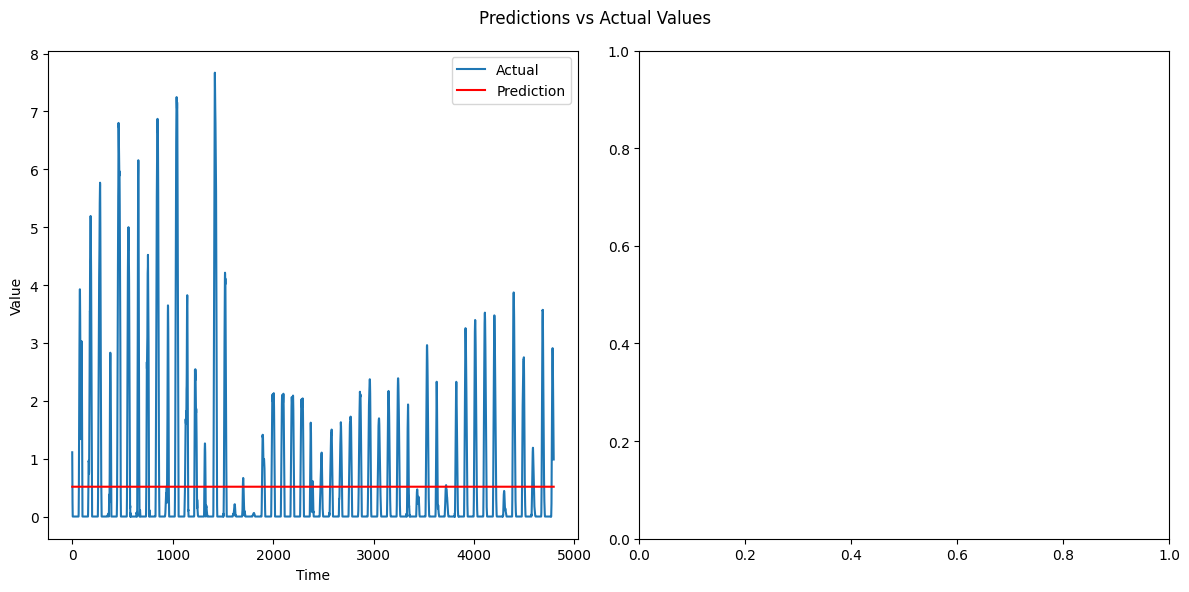

KeyboardInterrupt: 

In [46]:
input_dim = 8 # number of features in the outdoor conditions and the indoor measurements
hidden_dim = 128
output_dim = 1  # the number of features in the output
num_epochs = 100
num_layers = 4
num_mixtures=5
learning_rate = 0.001
weight_decay = 0.8
Fold = 0

Predictions = np.zeros((6, 4794, 1))
Test = np.zeros((6, 4794, 1))
kf = KFold(n_splits=10)
model = LSTMModel(input_dim, output_dim, output_dim  ,num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=weight_decay)
for train_index, test_index in kf.split(all_new_features_train):
    train_input = all_new_features_train[train_index]
    train_target = target[train_index]
    test_input = all_new_features_train[test_index]
    test_target = target[test_index]
    for epoch in range(num_epochs):
        model.train()  # training
        outputs = model(train_input)
        outputs = outputs.view(train_input.shape[0], 4794, 1)
        loss = criterion(outputs, train_target)
        optimizer.zero_grad()
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    model.eval()  # testing
    with torch.no_grad():
     sample_input = test_input
     predictions = model(sample_input)
     Predictions[Fold] = predictions.numpy()
     Test[Fold] = test_target.numpy()
     mse = F.mse_loss(predictions, test_target)
     print("Mean Squared Error (MSE):", mse.item())

    # Plotting the predictions against the actual values
     x = range(test_target.shape[1])
     fig, axs = plt.subplots(1, 2, figsize=(12, 6))
     for i, axs in enumerate(axs.flat):
        axs.plot(x, test_target[i].flatten(), label='Actual')
        axs.plot(x, predictions[i].flatten(), label='Prediction', color='red')
        axs.set_xlabel('Time')
        axs.set_ylabel('Value')
        axs.legend()
        break
     fig.suptitle('Predictions vs Actual Values')
     plt.tight_layout()
     plt.show()

     Fold += 1
     if Fold ==2:
        break

In [ ]:
x = range(Predictions.shape[1]) 
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for i, axs in enumerate(axs.flat):
    axs.plot(x, Test[i], label='Actual')
    axs.plot(x, Predictions[i], label='Prediction',color='red')
    print(Predictions[i])
    axs.set_xlabel('Time')
    axs.set_ylabel('Average')
    axs.legend()
    axs.set_ylim([0, 10])
fig.suptitle('Predictions for 1_sun with cross validation ', fontsize=15)
plt.savefig('training.pdf')
plt.tight_layout()
plt.show()

In [ ]:
all_new_features_test=all_new_features[10:12,:,:].astype(np.float32)

'''num_samples, num_features, num_channels = all_new_features_test.shape
all_new_features_2d = np.reshape(all_new_features_test, (num_samples, num_features * num_channels))
all_new_features_test_scaled = scaler1.transform(all_new_features_2d)
all_new_features_test_scaled= np.reshape(all_new_features_test_scaled , (num_samples, num_features, num_channels))'''
outdoor_panels_power_0 = outdoor_panels_power_average[10:12].astype(float)
'''all_new_features_test_scaled = scaler1.transform(all_new_features_test.reshape(-1, 1)).reshape(all_new_features_test.shape)'''
model.eval()
loss = []
 
outdoor_panels_power_t0 = torch.from_numpy(outdoor_panels_power_0).to(device)
all_new_features_test_0=torch.from_numpy(all_new_features_test).float().to(device)
'''outdoor_conditions_stacked_t2 = torch.from_numpy(outdoor_conditions_stacked[30:32]).float().to(device)'''
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i, axs in enumerate(axs.flat):
    with torch.no_grad():
        train_in = all_new_features_test_0[i:i+1, :, :]
        target_test = outdoor_panels_power_t0[i:i+1, :, :]
        pred = model(train_in)
        mse = F.mse_loss(pred[0], outdoor_panels_power_t0[i])
        loss.append(mse.item())
        x = range(target_test.shape[1])
        axs.plot(x, target_test[0], label='Actual')
        axs.plot(x, pred[0], label='Prediction',color='red')
        print(pred[0])
        axs.set_title("Panel {}: MSE = {:.4f}".format(i+1, mse.item()))
        axs.set_xlabel('Time')
        axs.set_ylabel('Average')
        axs.legend()
        axs.set_ylim([0, 18])
plt.tight_layout() 
plt.savefig("testing.pdf")
print(np.mean(loss))
plt.show()